In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reset -sf

In [3]:
import importlib
import Deproject_v1_0 
from Deproject_test import *
from Deproject_plots import *
import matplotlib.pyplot as plt
from scipy import sparse as scisp
from scipy.optimize import approx_fprime
import os
import cProfile
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from timeit import default_timer as timer

from astropy.io.ascii import read as tableread
import astropy.units as u
import astropy.coordinates as coord

coord.Galactic()
%cd ~/DeprojectionProject/

[Errno 2] No such file or directory: '/home/mikkola/DeprojectionProject/'
/home/mikkola/Documents/DeprojectionProject


In [4]:
%cd ~/Documents/faststats/faststats/
from fkde import *
def kdeplot(x,y,grid,no_c,bw_a):
    Z,ax = fastkde(x,y,gridsize=grid,nocorrelation=no_c,adjust=bw_a)#,weights,adjust)
    xlen,ylen = np.shape(Z)
    X,Y = np.meshgrid(np.linspace(ax[0],ax[1],xlen),np.linspace(ax[0],ax[1],ylen))
    return X,Y,Z
%cd ~/DeprojectionProject/

[Errno 2] No such file or directory: '/home/mikkola/Documents/faststats/faststats/'
/home/mikkola/Documents/DeprojectionProject


ModuleNotFoundError: No module named 'fkde'

In [5]:
def rot(x,y,deg):
    xf = x.flatten(); xf = xf.reshape(len(xf),1)
    yf = y.flatten(); yf = yf.reshape(len(yf),1)
    pos = np.hstack((xf,yf))
    
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    pos = np.dot(pos, R.T)
    
    x = pos[:,0].reshape(x.shape)
    y = pos[:,1].reshape(y.shape)
    return x,y

def f(x,y,z,lim):
    x,y = rot(x,y,45)
    val = (lim-np.abs(x))**4 + (lim-np.abs(y))**4 + (lim-np.abs(z))**4
    return val/np.sum(val)


def pyramid_sample(N_sample,r,c):
    # Velocities
    xc,yc,zc = c
    N = 100
    X = np.linspace(-r,r,N)
    Y = np.linspace(-r,r,N)
    Z = np.linspace(-r,r,N)
    
    XX = X.reshape(1,N,1)*np.ones((N,1,N))
    YY = Y.reshape(N,1,1)*np.ones((1,N,N))
    ZZ = Z.reshape(1,1,N)*np.ones((N,N,1))
    
    P = f(XX,YY,ZZ,r+np.max(c))
    
    rrind = np.ravel_multi_index(np.indices(XX.shape), XX.shape).ravel()
    prob = np.ravel(P)
    smp = np.random.choice(rrind, size=N_sample, p=prob)
    smpx, smpy, smpz = np.asarray(np.unravel_index(smp, XX.shape))
    
    XX = XX + xc
    ZZ = YY + yc
    YY = ZZ + zc
    
    vxvals = XX[smpx, smpy, smpz]
    vyvals = YY[smpx, smpy, smpz]
    vzvals = ZZ[smpx, smpy, smpz]
    
    # Positions
    xmax, ymax, zmax = np.array([100,100,100])/np.sqrt(3)    
    xmin, ymin, zmin = -xmax,-ymax,-zmax
    
    xvals = (np.random.rand(N_sample) * (xmax - xmin) + xmin)
    yvals = (np.random.rand(N_sample) * (ymax - ymin) + ymin)
    zvals = (np.random.rand(N_sample) * (zmax - zmin) + zmin)
    return xvals, yvals, zvals, vxvals, vyvals, vzvals

## Generate gaussian sample

In [ ]:
N = 5000 #Number of stars we want to use in our sample
sample, vx, vy, vz = Deproject_v1_0.model_sample(N)

In [ ]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Generate pyramid-like sample from distribution

In [ ]:
np.random.seed(0)
x, y, z, vx, vy, vz = pyramid_sample(int(1e4),100, c=(0,0,0))

In [ ]:
x,y,z          = (x,y,z)* u.pc
vx,vy,vz       = (vx,vy,vz) * (u.km / u.s)

In [ ]:
# We use Astropy's coord class which makes it easy to keep track of units and conversions

sample = coord.Galactic(u=x,
                         v=y, 
                         w=z,
                         U=vx,
                         V=vy,
                         W=vz,
                         representation_type=coord.CartesianRepresentation,
                         differential_type=coord.CartesianDifferential)
sample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)



In [ ]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Generate  fake Galactic samples

From simulated galaxy:

Loading data

In [ ]:
N = 5000 #Number of stars we want to use in our sample
dat = np.load('DATA/simgal.npy')

Select a sample around with radius 2 kpc around 8 kpc

In [ ]:
x,y,z,vx,vy,vz = dat
R = np.sqrt((x-8)**2 + y**2)
snbh = R < 2
dat = dat[:,snbh]
I = np.random.randint(low=0,high=np.sum(snbh),size=N)

x,y,z,vx,vy,vz = dat[:,I]

# Center x, y and vy, so they look like they're relative to the LSR
x = x - np.median(x)
y = y - np.median(y)
vy = vy - np.median(vy)

Prepare for astropy

In [ ]:
x,y,z          = (x,y,z)* u.pc
vx,vy,vz       = (vx,vy,vz) * (u.km / u.s)

In [ ]:
# We use Astropy's coord class which makes it easy to keep track of units and conversions

sample = coord.Galactic(u=x,
                         v=y, 
                         w=z,
                         U=vx,
                         V=vy,
                         W=vz,
                         representation_type=coord.CartesianRepresentation,
                         differential_type=coord.CartesianDifferential)
sample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)


In [ ]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Inspect sample

In [ ]:
plt.hist2d(np.array(sample.l),np.array(sample.b),100)
plt.show()

True distribution

In [ ]:
n = np.array([20,20,20])
dv = np.array([10,10,10])
vmin = np.array([-100,-100,-100])

In [ ]:
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

sigma = np.sqrt(sigma2)
phi0 = phi_guess(vmean0,sigma,vmin,dv,n)

sanity_check(pvals,rhatvals,phi0,vmin,dv,n)

In [ ]:
alpha_guess = 1e-8

v_guess = np.array([1,1,1])
disp_guess = np.array([22,17,30])

t0 = timer()
mxl, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess)
time = str((timer() - t0)/60)
print(time + ' mins')

sanity_check(pvals,rhatvals,mxl,vmin,dv,n)

In [ ]:
dx, dy = dv[0], dv[1]
vxmin, vymin = vmin[0], vmin[1]
nx, ny = n[0], n[1]
vxmax, vymax = vxmin+nx*dx,vymin+ny*dy

x0, y0 = vxmin, vymin
x1, y1 = vxmax, vymax

xbins = np.arange(x0,x1+dx,dx)
ybins = np.arange(y0,y1+dy,dy)

xc = (xbins[1:]+xbins[:-1])/2
yc = (ybins[1:]+ybins[:-1])/2

[X,Y] = np.meshgrid(xc,yc);

fv = np.exp(mxl)

fvlog = np.log10(fv+1)
xl = 120
yl = 120
twodfv = np.sum(fv,axis=2)
plt.figure()
plt.contourf(X,Y,twodfv.T,40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
plt.contour(X,Y,twodfv.T,10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-xl,xl)
plt.ylim(-yl,yl)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.title('Deprojected fv')

X2,Y2,Z = kdeplot(np.array(vx),np.array(vy),(50,50),False,2)
Z,xbins,ybins = np.histogram2d(np.array(vx),np.array(vy),20)
xc = (xbins[1:]+xbins[:-1])/2
yc = (ybins[1:]+ybins[:-1])/2

[X2,Y2] = np.meshgrid(xc,yc);

plt.figure()
#plt.contourf(X2,Y2,Z.T,40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
plt.pcolormesh(X2,Y2,Z.T,cmap='bone_r')
plt.contour(X2,Y2,Z.T,10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-xl,xl)
plt.ylim(-yl,yl)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.title('Original fv')

plt.figure()
plt.contourf(X,Y,np.log10(twodfv.T),40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
plt.contour(X,Y,np.log10(twodfv.T),10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-xl,xl)
plt.ylim(-yl,yl)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.title('Deprojected log(fv)')
plt.show()

Investigating grad_L

In [ ]:
f,ax = plt.subplots(5,4,sharex=True,sharey=True,figsize=(20,20),frameon=False)

k = 0
for i in range(5):
    for j in range(4):
        ax[i,j].pcolormesh(mxl[:,:,k],cmap = plt.cm.get_cmap('viridis'))
        ax[i,j].set_title('z sheet %s' % k)
        k += 1
plt.show()

## Alternative sec_der

In [ ]:
from scipy.interpolate import interpn

def plotphi(phi):
    plt.figure(figsize=(4,3))
    im = plt.pcolormesh(phi.T,cmap = plt.cm.get_cmap('viridis'))
    plt.colorbar(im)
    plt.show()

def extrapolate_box(box):
    (nx,ny,nz) = box.shape

    points = (np.arange(1,nx-1), 
              np.arange(1,ny-1),
              np.arange(1,nz-1))

    IA = np.indices(box.shape).transpose(3,1,2,0)

    xedges = np.concatenate((IA[:,0,:,:].reshape(nx**2,3), IA[:,-1,:,:].reshape(nx**2,3)), axis=0)
    yedges = np.concatenate((IA[:,:,0,:].reshape(ny**2,3), IA[:,:,-1,:].reshape(ny**2,3)), axis=0)
    zedges = np.concatenate((IA[0,:,:,:].reshape(nz**2,3), IA[-1,:,:,:].reshape(nz**2,3)), axis=0)
    edge_coords = np.concatenate((xedges,yedges,zedges),axis=0)
    edge_coords = np.unique(edge_coords,axis=0) # remove duplicate entries

    I_edges = np.ones((nx,ny,nz),dtype=bool)
    I_edges[1:-1,1:-1,1:-1] = np.zeros((nx-2,ny-2,nz-2),dtype=bool)
    edge_vals = interpn(points, box[1:-1, 1:-1, 1:-1], edge_coords, method='linear', bounds_error=False, fill_value=None)
    box[I_edges] = edge_vals
    return box



def sec_der(phi, sigma2, dv):

    nx, ny, nz = phi.shape
    dvx, dvy, dvz = dv
    dv2 = dv ** 2
    sigma2x, sigma2y, sigma2z = sigma2

    nxx, nyy, nzz = nx + 2, ny + 2, nz + 2

    phip = np.zeros((nxx, nyy, nzz))  # new larger box
    plotphi(phi[:,:,9])
    phip[1:-1, 1:-1, 1:-1] = phi  # puts the phi-box in the centre of our larger box
    extrapolate_box(phip)
    plotphi(phip[:,:,9])


    phi_fac = np.array([phip[0:nxx - 2, 1:-1, 1:-1] + phip[2:nxx, 1:-1, 1:-1],
                        phip[1:-1, 0:nyy - 2, 1:-1] + phip[1:-1, 2:nyy, 1:-1],
                        phip[1:-1, 1:-1, 0:nzz - 2] + phip[1:-1, 1:-1, 2:nzz]])

    phi_arrx = (sigma2[0] / dv2[0]) * (phi_fac[0] - 2 * phi)
    phi_arry = (sigma2[1] / dv2[1]) * (phi_fac[1] - 2 * phi)
    phi_arrz = (sigma2[2] / dv2[2]) * (phi_fac[2] - 2 * phi)
    plotphi(phi_arrx[1:-1, 1:-1,9])

    phi_arr = phi_arrx + phi_arry + phi_arrz
    plotphi(phi_arr[:,:,9])
    extrapolate_box(phi_arr)
    plotphi(phi_arr[:,:,9])
    return phi_arr

In [ ]:
%cd DATA/
pvals = np.load('TEST/pvals.npy')
rhatvals = np.load('TEST/rhatvals.npy')
mxl = np.load('TEST/mxl.npy')

In [ ]:
Kvals = KvalsNumpyMethod(pvals, rhatvals, vmin, dv, n)

In [ ]:
args = (Kvals, len(pvals), alpha_guess, dv, n, sigma2)

In [ ]:
get_negL(mxl.ravel(),Kvals, len(pvals), alpha_guess, dv, n, sigma2)

In [ ]:
Kvals, N, alpha, dv, n, sigma2 = args
nx, ny, nz = n
dvx, dvy, dvz = dv
phi = np.ravel(mxl)

In [ ]:
plotphi(phi_arr[1:-1, 1:-1,9])
phi_arr[1:-1, 1:-1, 1:-1] = np.min(phi_arr)
plotphi(phi_arr[1:-1, 1:-1,9])
extrapolate_box(phi_arr)
plotphi(phi_arr[1:-1, 1:-1,9])

In [ ]:
phi_arr = sec_der(phi0, sigma2, dv)

In [ ]:
1e-12-3

In [ ]:
f,ax = plt.subplots(5,8,sharex=True,sharey=True,figsize=(12,8),frameon=False)

k = 0
for i in range(5):
    k = [z+i for z in range(0,20,5)]
    for j in range(4):
        ax[i,j*2].pcolormesh(phi_arr[:,:,k[j]].T,cmap = plt.cm.get_cmap('viridis'))
        ax[i,j*2].set_title('z sheet %s' % k[j])

        ax[i,j*2+1].pcolormesh(phi0[:,:,k[j]].T,cmap = plt.cm.get_cmap('viridis'))
        ax[i,j*2+1].set_title('z sheet %s' % k[j])
plt.tight_layout()
plt.show()

In [6]:
def plotphi(phi):
    plt.figure(figsize=(4,3))
    im = plt.pcolormesh(phi.T,cmap='bone_r')
    plt.contour(phi.T,10,origin='lower',colors='k',linewidths=0.5)
    plt.colorbar(im)
    plt.show()
#phip[1:-1, 1:-1] = phi2d 

In [ ]:
def model_sample_2(N):
    """Generates a simple model solar neighbourhood star sample in a Galactic frame of reference assuming a
    velocity distribution that is a sum of three predefined 3DGaussians.

    If one wishes to use other mean velocities, change these in mu0, mu1 and mu2, while the dispersions are changed
    in disp0, disp1 and disp2. The relative weights, w1, w2, w3 determine how many of the stars that belong to
    each Gaussian. As for now, they're just set to be ~1/3.

    The stars have distances from the Sun that are in the range [10,100] pc.

    Takes the following arguments:

    N: Number of stars in the sample"""

    xmax, ymax, zmax = np.array([100,100,100])/np.sqrt(3)    
    xmin, ymin, zmin = -xmax,-ymax,-zmax
    #w0 = 1.
    #w1 = 0.
    w0 = w1 = 0.33
    w2 = 1-(w0+w1)

    #mu0 = np.array([0,0,0])
    mu0 = np.array([30,30,30])
    mu1 = np.array([-20,-20,-20])
    mu2 = np.array([15,-15,15])

    disp0 = np.array([25,23,27])
    disp1 = np.array([13,17,15])
    disp2 = np.array([9,14,12])

    w_sample = np.random.random_sample(N)

    psx = (np.random.rand(N) * (xmax - xmin) + xmin) * u.pc
    psy = (np.random.rand(N) * (ymax - ymin) + ymin) * u.pc
    psz = (np.random.rand(N) * (zmax - zmin) + zmin) * u.pc

    from_g0 = np.where(w_sample < w0)  # We get the indices of the stars that belong to the first Gaussian
    from_g1 = np.where((w0 <= w_sample) & (w_sample < (w0 + w1)))
    from_g2 = np.where(w_sample > (1 - w2))

    scale0 = np.random.randn(len(from_g0[0]), 3)
    scale1 = np.random.randn(len(from_g1[0]), 3)
    scale2 = np.random.randn(len(from_g2[0]), 3)

    psvels = np.zeros((N, 3))

    psvels[
        from_g0] = mu0 + scale0 * disp0  # We exchange our empty velocity values with the ones obtained from each Gaussian
    psvels[from_g1] = mu1 + scale1 * disp1
    psvels[from_g2] = mu2 + scale2 * disp2

    psvx, psvy, psvz = psvels.T
    # We use Astropy's coord class which makes it easy to keep track of units and conversions

    psample = coord.Galactic(u=psx, v=psy, w=psz, U=psvx * (u.km / u.s),
                             V=psvy * (u.km / u.s), W=psvz * (u.km / u.s),
                             representation_type=coord.CartesianRepresentation,
                             differential_type=coord.CartesianDifferential)

    psample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)
    return psample, psvx, psvy, psvz

In [ ]:
X2,Y2,Z = kdeplot(np.array(vx),np.array(vy),(50,50),False,2)
Z,xbins,ybins = np.histogram2d(np.array(vx),np.array(vy),20)
xc = (xbins[1:]+xbins[:-1])/2
yc = (ybins[1:]+ybins[:-1])/2

[X2,Y2] = np.meshgrid(xc,yc);

plt.figure()
plt.pcolormesh(X2,Y2,Z.T,cmap='bone_r')
plt.contour(X2,Y2,Z.T,10,origin='lower',colors='k',linewidths=0.5)
plt.xlim(-xl,xl)
plt.ylim(-yl,yl)
plt.gca().add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
plt.legend()
plt.title('Original fv')

## Check eq 30 on 1d Gaussian

$$ \Xi_{\pmb{n}\pmb{l}} \propto -2\delta_{\pmb{n},\pmb{l}} + \delta_{\pmb{n},\pmb{l} + \pmb{\hat{e}}_i} + \delta_{\pmb{n},\pmb{l} - \pmb{\hat{e}}_i}$$

$$f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} \rightarrow \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2}$$

$$f'(x) =  -\frac{x}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2}$$

$$f"(x) =  \frac{x^2 - 1}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2}$$

In [ ]:
def f_gauss(x):
    return np.exp(-0.5*x**2) / np.sqrt(2*np.pi)

def f_gauss_bis(x):
    return (x**2 - 1)*f_gauss(x)



In [ ]:
x = np.linspace(-5,5,15)
vals = f_gauss(x)
sec_der_vals = f_gauss_bis(x)
xi_vals = vals[2:] + vals[:-2] - 2*vals[1:-1]

plt.figure()
plt.plot(x,vals,'b')
plt.plot(x,sec_der_vals,'r')
plt.plot(x[1:-1],xi_vals,'g')

In [ ]:
%matplotlib inline
from ipywidgets import *

def f_gauss(x):
    return np.exp(-0.5*x**2) / np.sqrt(2*np.pi)

def f_gauss_bis(x):
    return (x**2 - 1)*f_gauss(x)

def xi_vals(vals):
    return vals[2:] + vals[:-2] - 2*vals[1:-1]

def x_vals(N):
    return np.linspace(-5,5,N)

def plot_func(N):
    x = x_vals(int(N))

    plt.plot(x,f_gauss(x),'b')
    plt.plot(x,f_gauss_bis(x),'r')
    plt.plot(x[1:-1],xi_vals(f_gauss(x)),'g')
    plt.show()

interact(plot_func, N = widgets.FloatSlider(value=10,
                                               min=5,
                                               max=50,
                                               step=5))

In [ ]:
def sec_der(phi, sigma2, dv):

    nx, ny, nz = phi.shape
    dvx, dvy, dvz = dv
    dv2 = dv ** 2
    sigma2x, sigma2y, sigma2z = sigma2

    nxx, nyy, nzz = nx + 2, ny + 2, nz + 2

    phip = np.zeros((nxx, nyy, nzz))  # new larger box
    phip[1:-1, 1:-1, 1:-1] = phi  # puts the phi-box in the centre of our larger box
    extrapolate_box(phip)


    phi_fac = np.array([phip[0:nxx - 2, 1:-1, 1:-1] + phip[2:nxx, 1:-1, 1:-1],
                        phip[1:-1, 0:nyy - 2, 1:-1] + phip[1:-1, 2:nyy, 1:-1],
                        phip[1:-1, 1:-1, 0:nzz - 2] + phip[1:-1, 1:-1, 2:nzz]])

    phi_arrx = (sigma2[0] / dv2[0]) * (phi_fac[0] - 2 * phi)
    phi_arry = (sigma2[1] / dv2[1]) * (phi_fac[1] - 2 * phi)
    phi_arrz = (sigma2[2] / dv2[2]) * (phi_fac[2] - 2 * phi)
    plotphi(phi_arrx[1:-1, 1:-1,9])

    phi_arr = phi_arrx + phi_arry + phi_arrz
    extrapolate_box(phi_arr)
    return phi_arr

In [35]:
N = 5000 #Number of stars we want to use in our sample
sample, vx, vy, vz = Deproject_v1_0.model_sample(N)
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

In [46]:
from scipy.ndimage import zoom

def params(N):
    n = N
    vmin = np.array([-150,-150,-150])
    vmax = np.array([150,150,150])
    dv = (vmax - vmin)/n
    return vmin, dv, n

def zoomed_mxl(mxl):
    phi0_guess = zoom(mxl, zoom=2, order=3)
    n = phi0_guess.shape
    return phi0_guess, n

alpha_guess = 1e-8
v_guess = np.array([1,1,1])
disp_guess = np.array([22,17,30])

vmin, dv, n = params(np.array([10,10,10]))

# duration = []

t0 = timer()
# 1st
mxl1, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess, disp=0)
time_spent = np.around((timer() - t0)/60, 3).astype(str) + ' mins'; t0 = timer()
print(str(time_spent))

i_mxl2, N = zoomed_mxl(mxl1)
vmin, dv, n = params(N)





# duration.append([])
####2nd
mxl2, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess, phi0_guess=i_mxl2, disp=0)
time_spent = np.around((timer() - t0)/60, 3).astype(str) + ' mins'; t0 = timer()
# duration[0].append(time_spent); print(str(time_spent))
duration[0][0] = time_spent
# ##2nd - b
# mxl2b, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess, disp=0)
# time_spent = np.around((timer() - t0)/60, 3).astype(str) + ' mins'; t0 = timer()
# duration[0].append(time_spent); print(str(time_spent))

i_mxl3, N = zoomed_mxl(mxl2)
vmin, dv, n = params(N)




# duration.append([])
####3rd
mxl3, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess, phi0_guess=i_mxl3, disp=0)
time_spent = np.around((timer() - t0)/60, 3).astype(str) + ' mins'; t0 = timer()
duration[1][0] = time_spent
# duration[1].append(time_spent); print(str(time_spent))
# ##3rd - b
# mxl3, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess, disp=0)
# time_spent = np.around((timer() - t0)/60, 3).astype(str) + ' mins'; t0 = timer()
# duration[1].append(time_spent); print(str(time_spent))

i_mxl4, N = zoomed_mxl(mxl3)
vmin, dv, n = params(N)
   
  


# duration.append([])
####4th
mxl4, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess, phi0_guess=i_mxl4, disp=0)
time_spent = np.around((timer() - t0)/60, 3).astype(str) + ' mins'; t0 = timer()
duration[2][0] = time_spent
# duration[2].append(time_spent); print(str(time_spent))
# ##4th - b
# mxl4b, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess, disp=0)
# time_spent = np.around((timer() - t0)/60, 3).astype(str) + ' mins'; t0 = timer()
# duration[2].append(time_spent); print(str(time_spent))


Run requires: 0.04 GB (120.0 GB available) | Block size = 15000000
Fast Numpy Kvals run possible, running...

Finished kvals.

Started fmin_cg...
0.47 mins
Run requires: 0.32 GB (120.0 GB available) | Block size = 1875000
Fast Numpy Kvals run possible, running...

Finished kvals.

Started fmin_cg...
Run requires: 2.56 GB (120.0 GB available) | Block size = 234375
Fast Numpy Kvals run possible, running...

Finished kvals.

Started fmin_cg...
Run requires: 20.48 GB (120.0 GB available) | Block size = 29296
Fast Numpy Kvals run possible, running...

Finished kvals.

Started fmin_cg...


In [58]:
tuple([10*(2**i)]*3)

(10, 10, 10)

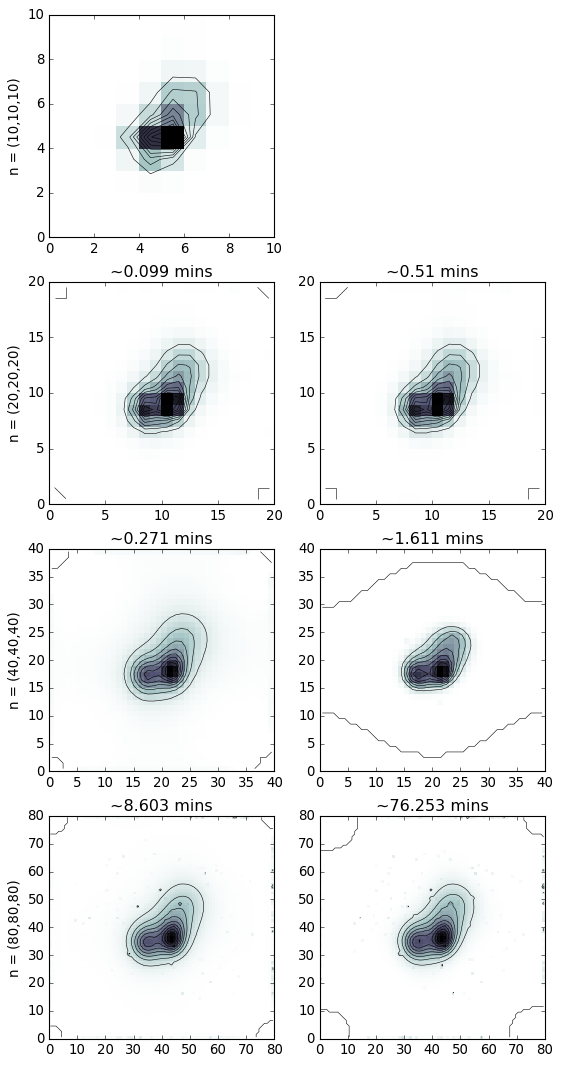

In [63]:
f,ax = plt.subplots(4,2,figsize=(8,16),frameon=False)

Z = np.log10(np.exp(mxl1) +1).sum(axis=2) 
ax[0,0].pcolormesh(Z.T,cmap='bone_r')
ax[0,0].contour(Z.T,10,origin='lower',colors='k',linewidths=0.5)
ax[0,0].set_ylabel('n = (%s,%s,%s)' % tuple([10]*3))
f.delaxes(ax[0,1])

rows = [[mxl2,mxl2b],[mxl3,mxl3b],[mxl4,mxl4b]]
for i, row in enumerate(rows):
    
    Z = np.log10(np.exp(row[0]) +1).sum(axis=2) 
    ax[i+1,0].pcolormesh(Z.T,cmap='bone_r')
    ax[i+1,0].contour(Z.T,10,origin='lower',colors='k',linewidths=0.5)
    ax[i+1,0].set_title('~' + duration[i][0])
    ax[i+1,0].set_ylabel('n = (%s,%s,%s)' % tuple([10*(2**(i+1))]*3))
    
    Z = np.log10(np.exp(row[1]) +1).sum(axis=2)
    ax[i+1,1].pcolormesh(Z.T,cmap='bone_r')
    ax[i+1,1].contour(Z.T,10,origin='lower',colors='k',linewidths=0.5)
    ax[i+1,1].set_title('~' + duration[i][1])


plt.savefig('multigrid.pdf',format='pdf')
# plotphi(np.log10(np.exp(mxl1) +1).sum(axis=2))
# plotphi(np.log10(np.exp(mxl2) +1).sum(axis=2))
# plotphi(np.log10(np.exp(mxl3) +1).sum(axis=2))
# plotphi(np.log10(np.exp(mxl4) +1).sum(axis=2))

In [ ]:
import psutil
psutil.virtual_memory()